In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

### 모델 파라미터 분석
- 입력 채널 수에 따른 모델의 자원 소모량을 추정

In [55]:
class DummyCNN(nn.Module):
    def __init__(self,
                 num_channel=[32, 40],
                 num_raw_features=55,
                 kernel_size=3,
                 stride=1,
                 input_length=50,  # L 입력 길이
                 ):
        super(DummyCNN, self).__init__()

        self.input_shape = (1, num_raw_features, input_length)
        self.conv_layers = nn.Sequential()
        prev_channels = num_raw_features
        length = input_length  # 시계열 길이

        # Conv + Pooling Layers
        for idx, out_channels in enumerate(num_channel):
            conv = nn.Conv1d(prev_channels, out_channels, kernel_size=kernel_size, stride=stride)
            self.conv_layers.add_module(f"conv{idx}", conv)
            self.conv_layers.add_module(f"relu{idx}", nn.ReLU())
            pool = nn.MaxPool1d(kernel_size=2)
            self.conv_layers.add_module(f"pool{idx}", pool)

            # Update length (for output shape tracking)
            length = (length - kernel_size) // stride + 1  # conv
            length = length // 2  # pooling

            prev_channels = out_channels

        # AdaptiveConcatPool1d → output shape: (B, 2C, 1)
        concat_channels = 2 * num_channel[-1]

        self.fc = nn.Sequential(
            nn.Flatten(),  # (B, 2C)
            nn.Linear(concat_channels, num_channel[-1]),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(num_channel[-1], num_raw_features)
        )

        # 저장용
        self.output_length = length
        self.final_channels = num_channel[-1]

    def forward(self, x):
        return self.fc(
            F.adaptive_avg_pool1d(self.conv_layers(x), 1).repeat(1, 2, 1)
        )

    def count_parameters(self):
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return {"total": total, "trainable": trainable}

    def summary(self):
        x = torch.randn(self.input_shape)
        with torch.no_grad():
            x = self.conv_layers(x)
            print(f"After conv layers: {x.shape}")
            x = F.adaptive_avg_pool1d(x, 1).repeat(1, 2, 1)  # mimic AdaptiveConcatPool1d
            print(f"After AdaptiveConcatPool1d: {x.shape}")
            x = x.flatten(1)
            print(f"Flattened: {x.shape}")
        print("Total parameters:", self.count_parameters())

In [59]:
records = []
for i in range(1, 56):
    model = DummyCNN(num_raw_features=i, input_length=50)
    info = summary(model, input_size=(1, i, 50), verbose=0)

    record = {
        'in_features': i,
        'total_input': info.to_megabytes(info.total_input),
        'total_mult_adds': info.total_mult_adds,
        'total_params': info.total_params,
        'total_param_bytes': info.to_megabytes(info.total_param_bytes),
    }

    records.append(record)

In [60]:
'''
for record in records:
    print(record)
'''

{'in_features': 1, 'total_input': 0.00028, 'total_mult_adds': 94785, 'total_params': 7289, 'total_param_bytes': 0.029156}
{'in_features': 2, 'total_input': 0.00048, 'total_mult_adds': 99434, 'total_params': 7426, 'total_param_bytes': 0.029704}
{'in_features': 3, 'total_input': 0.00068, 'total_mult_adds': 104083, 'total_params': 7563, 'total_param_bytes': 0.030252}
{'in_features': 4, 'total_input': 0.00088, 'total_mult_adds': 108732, 'total_params': 7700, 'total_param_bytes': 0.0308}
{'in_features': 5, 'total_input': 0.00108, 'total_mult_adds': 113381, 'total_params': 7837, 'total_param_bytes': 0.031348}
{'in_features': 6, 'total_input': 0.00128, 'total_mult_adds': 118030, 'total_params': 7974, 'total_param_bytes': 0.031896}
{'in_features': 7, 'total_input': 0.00148, 'total_mult_adds': 122679, 'total_params': 8111, 'total_param_bytes': 0.032444}
{'in_features': 8, 'total_input': 0.00168, 'total_mult_adds': 127328, 'total_params': 8248, 'total_param_bytes': 0.032992}
{'in_features': 9, '

In [61]:
list_in_features = [record['in_features'] for record in records]
list_total_input = [record['total_input'] for record in records]
list_total_mult_adds = [record['total_mult_adds'] for record in records]
list_total_params = [record['total_params'] for record in records]
list_total_param_bytes = [record['total_param_bytes'] for record in records]

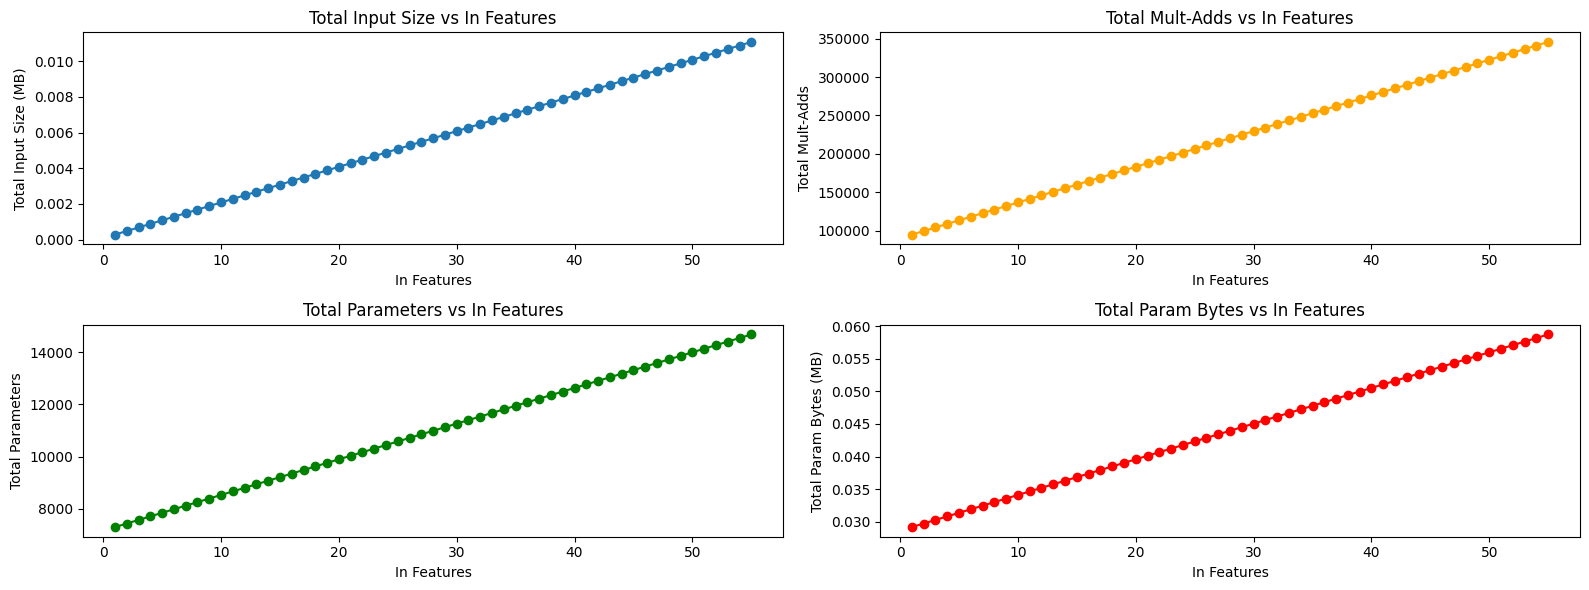

In [62]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 6))

axes[0, 0].plot(list_in_features, list_total_input, marker='o')
axes[0, 0].set_title('Total Input Size vs In Features')
axes[0, 0].set_xlabel('In Features')
axes[0, 0].set_ylabel('Total Input Size (MB)')

axes[0, 1].plot(list_in_features, list_total_mult_adds, marker='o', color='orange')
axes[0, 1].set_title('Total Mult-Adds vs In Features')
axes[0, 1].set_xlabel('In Features')
axes[0, 1].set_ylabel('Total Mult-Adds')

axes[1, 0].plot(list_in_features, list_total_params, marker='o', color='green')
axes[1, 0].set_title('Total Parameters vs In Features')
axes[1, 0].set_xlabel('In Features')
axes[1, 0].set_ylabel('Total Parameters')

axes[1, 1].plot(list_in_features, list_total_param_bytes, marker='o', color='red')
axes[1, 1].set_title('Total Param Bytes vs In Features')
axes[1, 1].set_xlabel('In Features')
axes[1, 1].set_ylabel('Total Param Bytes (MB)')

plt.tight_layout()
plt.show()